# Create Dataset Sample

In [9]:
from astropy.io import fits
import pandas as pd
import numpy as np

# Read the DR16 Catalog
f = "../Thesis/DR16Q_v4.fits"
with fits.open(f, memmap=True) as hdu_list:
    data0 = hdu_list[1].data

# Convert relevant columns to a DataFrame
df = pd.DataFrame({
    'PLATE': data0['PLATE'].byteswap().newbyteorder(),
    'MJD': data0['MJD'].byteswap().newbyteorder(),
    'FIBERID': data0['FIBERID'].byteswap().newbyteorder(),
    'SNR': data0['SN_MEDIAN_ALL'].byteswap().newbyteorder(),
    'Z': data0['Z'].byteswap().newbyteorder(),
    'RA': data0['RA'].byteswap().newbyteorder(),
    'DEC': data0['DEC'].byteswap().newbyteorder(),
})

# Add duplicate-related columns as lists
df['PLATES'] = list(data0['PLATE_DUPLICATE'])
df['MJDS'] = list(data0['MJD_DUPLICATE'])
df['FIBERIDS'] = list(data0['FIBERID_DUPLICATE'])

# Filter for Z and SNR
df = df[(df['Z'] >= 1.76923) & (df['Z'] <= 2.85185) & (df['SNR'] >= 6)]

# Remove quasars without valid duplicates
df = df[df['PLATES'].apply(lambda x: any(i != -1 for i in x))]

# Refine duplicates by filtering out -1 values
def refine_duplicates(column):
    return column.apply(lambda x: [i for i in x if i != -1])

df['PLATES'] = refine_duplicates(df['PLATES'])
df['MJDS'] = refine_duplicates(df['MJDS'])
df['FIBERIDS'] = refine_duplicates(df['FIBERIDS'])
df = df.reset_index(drop=True)

# Total number of available Duplicates per quasar
df['DUPLICATES'] = [len(i) for i in df['PLATES']]
df = df.sort_values('DUPLICATES',ascending=True)
df = df.reset_index(drop=True)

# Total possible ratio spectra available per sample space

/var/folders/4t/j_nn7fnn2xb1h112k0kt_q1c0000gn/T/ipykernel_29687/3720692552.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


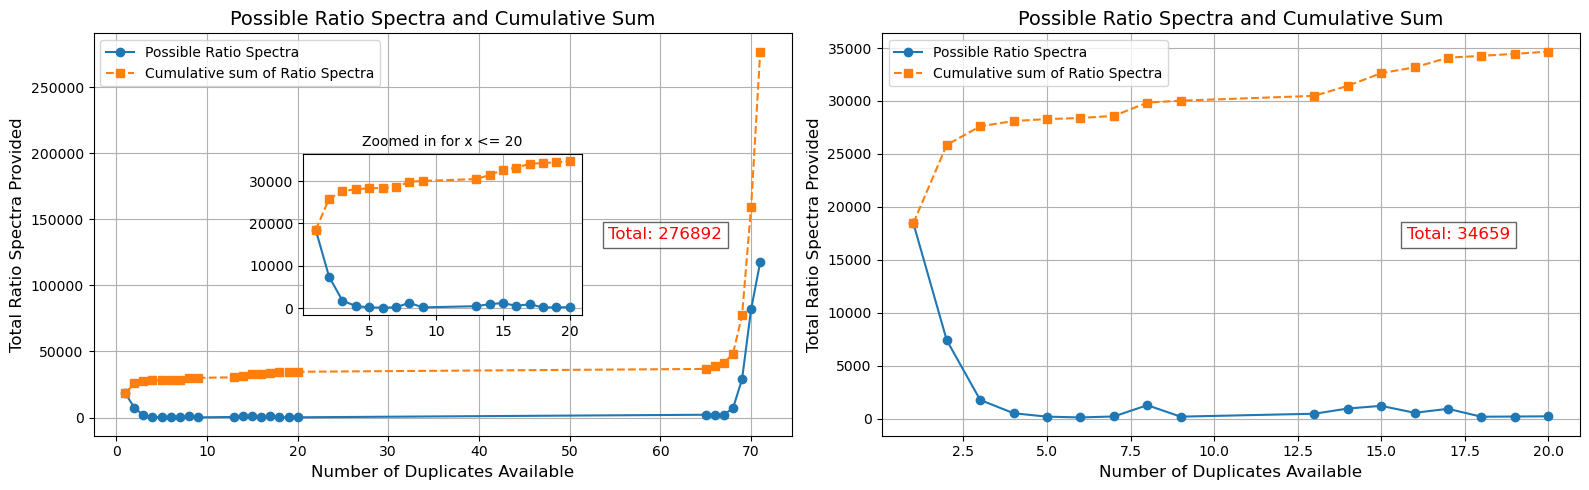

In [10]:
def Total_Possible_RatioSpectra(df, ax, flag=1):
    import math
    from itertools import accumulate
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Create a dictionary of duplicate counts
    a = dict(df.value_counts('DUPLICATES'))
    a = dict(sorted(a.items()))

    # Compute points
    pts = [(i, math.comb(i + 1, 2) * a[i]) for i in a]

    # Extract x and y values
    x, y = zip(*pts)

    # Compute cumulative sum for y
    y_cumsum = list(accumulate(y))

    # Plot on the provided axes
    ax.plot(x, y, label="Possible Ratio Spectra", marker="o")
    ax.plot(x, y_cumsum, label="Cumulative sum of Ratio Spectra", marker="s", linestyle="--")
    ax.set_xlabel("Number of Duplicates Available", fontsize=12)
    ax.set_ylabel("Total Ratio Spectra Provided", fontsize=12)
    ax.set_title("Possible Ratio Spectra and Cumulative Sum", fontsize=14)
    ax.text(0.9, 0.5, f"Total: {y_cumsum[-1]}", transform=ax.transAxes, 
        fontsize=12, color='red', ha='right', va='center', bbox=dict(facecolor='white', alpha=0.6))
    ax.legend()
    ax.grid()

    if flag == 1:
        # Add inset plot
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='center')
        x_inset = [val for val in x if val <= 20]
        y_inset = [y[i] for i, val in enumerate(x) if val <= 20]
        y_cumsum_inset = [y_cumsum[i] for i, val in enumerate(x) if val <= 20]

        # Plot on inset
        ax_inset.plot(x_inset, y_inset, label="y values", marker="o")
        ax_inset.plot(x_inset, y_cumsum_inset, label="Cumulative sum", marker="s", linestyle="--")
        ax_inset.set_title("Zoomed in for x <= 20", fontsize=10)
        ax_inset.grid()


# Example Usage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# First subplot
Total_Possible_RatioSpectra(df, axes[0], flag=1)

# Second subplot with filtered data
df0 = df[df['DUPLICATES'] < 30]
Total_Possible_RatioSpectra(df0, axes[1], flag=0)

# Adjust layout
plt.tight_layout()
plt.show()

# Ratio Identifiers and Exploded Path ways

In [11]:
from itertools import combinations

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df0 = df.copy()

# Function to generate ratio-identifier rows
def create_ratio_identifiers(row):
    primary = (row['PLATE'], row['MJD'], row['FIBERID'])
    duplicates = zip(row['PLATES'], row['MJDS'], row['FIBERIDS'])

    # Include primary and all duplicates in combinations
    all_spectra = [primary] + list(duplicates)
    identifiers = []

    # Generate all NC2 combinations
    for combo in combinations(all_spectra, 2):
        id1 = f"{combo[0][0]}-{combo[0][1]}-{combo[0][2]}"
        id2 = f"{combo[1][0]}-{combo[1][1]}-{combo[1][2]}"
        identifiers.append(f"spec-{id1}-{id2}")

    return identifiers

# Apply the function to each row and explode the dataframe
df0['ratio_identifiers'] = df0.apply(create_ratio_identifiers, axis=1)

df_exploded = df0.explode('ratio_identifiers').reset_index(drop=True)

# Keep only required columns and rename for clarity
df_exploded = df_exploded[['PLATE', 'MJD', 'FIBERID','Z', 'ratio_identifiers']]

df_exploded.to_csv('HCT_Cycle.csv',index=False)

In [12]:
df

,PLATE,MJD,FIBERID,SNR,Z,RA,DEC,PLATES,MJDS,FIBERIDS,DUPLICATES
0,8740,57367,717,12.979598,1.782729,0.028252,6.417215,[11279],[58449],[62],1
1,5863,56042,152,12.099537,2.386000,197.638893,18.159801,[2604],[54484],[329],1
2,5421,55980,912,14.050253,1.880000,197.635899,10.956882,[1796],[53884],[445],1
3,7410,57104,922,7.830501,2.315000,197.635505,49.770035,[6753],[56399],[624],1
4,6624,56385,284,9.118654,2.280000,197.624591,45.539236,[6621],[56366],[868],1
...,...,...,...,...,...,...,...,...,...,...,...
21452,7339,57510,817,11.008112,1.908000,214.170380,53.115956,"[7338, 7339, 7340, 7338, 7339, 7339, 7338, 734...","[57127, 56795, 58258, 57843, 56686, 56720, 570...","[818, 817, 820, 818, 817, 839, 816, 838, 816, ...",71
21453,7339,57544,360,8.806484,2.671000,213.070952,52.857632,"[7338, 7339, 7339, 7339, 7339, 7338, 7338, 733...","[57050, 56749, 57934, 56804, 56768, 56717, 571...","[359, 358, 380, 358, 348, 357, 357, 356, 377, ...",71
21454,7339,56722,194,6.019890,2.160000,214.313310,53.051047,"[7339, 7338, 7338, 7338, 7339, 7339, 7339, 733...","[56697, 57038, 57127, 57050, 56720, 56683, 567...","[220, 199, 197, 197, 188, 220, 200, 200, 199, ...",71
21455,7339,57510,391,10.137285,2.730000,212.898160,52.804018,"[7339, 7340, 7339, 7338, 7339, 7339, 7027, 733...","[56715, 58258, 57481, 57805, 57544, 57082, 564...","[415, 400, 391, 402, 387, 397, 900, 395, 399, ...",71


Uploaded the exploded dataset into sciserver and ran a code to find and copy the file paths of both the files into two separate columns. The algorithm would read the two spectra and then create a ratio spectrum and add it to the dataset. This will be downloaded and then processed further. This code is given in the File called `SciServer_Variability_Code`

# Delta MJD Distribution

In [16]:
import pandas as pd
import itertools

# Function to calculate Delta MJD
def calculate_delta_mjd(row):
    # Combine MJDS and MJD into a new list
    mjds = row['MJDS'] + [row['MJD']]
    # Pairwise ΔMJD within the combined list
    delta_mjds = [abs(a - b)/(1+row['Z']) for a, b in itertools.combinations(mjds, 2)]
    return delta_mjds

# Apply the function to calculate Delta MJD
df['Delta_MJD'] = df.apply(calculate_delta_mjd, axis=1)
df0['Delta_MJD'] = df0.apply(calculate_delta_mjd, axis=1)

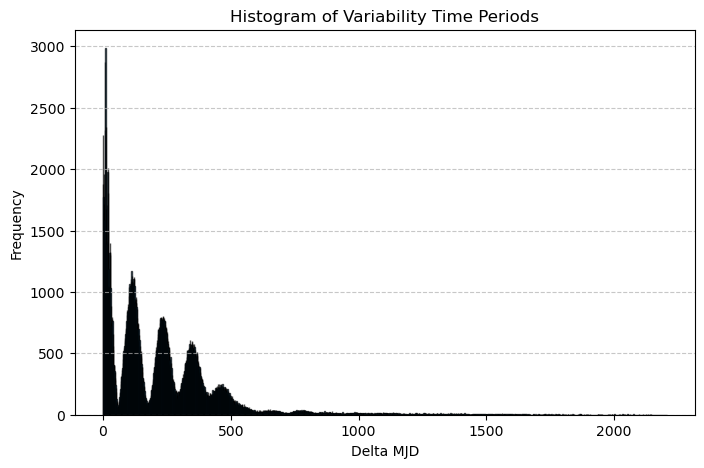

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all lists into a single list
combined_list = [item for sublist in df['Delta_MJD'] for item in sublist]

# Plot a histogram
plt.figure(figsize=(8, 5))
plt.hist(combined_list, bins=range(int(min(combined_list)), int(max(combined_list)) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Delta MJD')
plt.ylabel('Frequency')
plt.title('Histogram of Variability Time Periods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

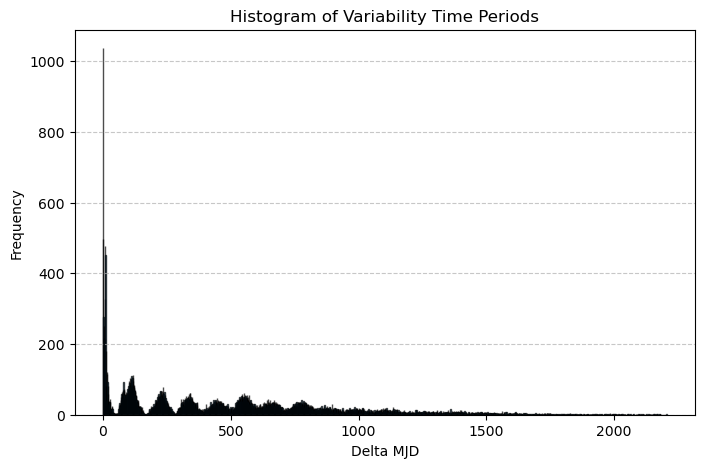

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all lists into a single list
combined_list = [item for sublist in df0['Delta_MJD'] for item in sublist]

# Plot a histogram
plt.figure(figsize=(8, 5))
plt.hist(combined_list, bins=range(int(min(combined_list)), int(max(combined_list)) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Delta MJD')
plt.ylabel('Frequency')
plt.title('Histogram of Variability Time Periods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()